In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk

In [121]:
def load_file(filepath):
	dataframe = pd.read_table(filepath,sep= ",",header=None, )
	return dataframe.values

In [122]:
test = load_file("wisdm-dataset/raw/phone/accel/data_1600_accel_phone.txt")
print("shape of test: ")
print(test.shape)
print(test[:-1])



shape of test: 
(64311, 6)
[[1600 'A' 252207666810782 -0.36476135 8.793503 '1.0550842;']
 [1600 'A' 252207717164786 -0.8797302 9.768784 '1.0169983;']
 [1600 'A' 252207767518790 2.0014954 11.10907 '2.619156;']
 ...
 [1600 'S' 244505711296204 -2.0469208 10.032288 '-1.2299347;']
 [1600 'S' 244505761650208 -1.3935394 9.883896 '-0.47924805;']
 [1600 'S' 244505812004212 -1.2304535 9.315079 '-0.15570068;']]


In [123]:
#load data for 1 person and clean it
def loadAndClean(filepath, filename):
    dataframe = pd.read_table(filepath+filename,sep= ",",header=None,
                              names=["ID","activity","NM","X","Y","Z"],
                              usecols=["ID","activity","NM","X","Y","Z"])
    dataframeclean = []
    dataframeclean = dataframe[(dataframe.activity == "A") | 
                               (dataframe.activity == "B") |
                               (dataframe.activity == "C") |
                               (dataframe.activity == "D") ]
    dataframeclean = dataframeclean.filter(items=["ID","activity","X","Y","Z"])
    for i in range(0,dataframeclean.shape[0]):
        dataframeclean.at[i,"Z"]= float(dataframeclean.at[i,"Z"].replace(";",""))
   
    #print(dataframeclean)
    
    return dataframeclean

ss = "wisdm-dataset/raw/phone/accel/data_1600_accel_phone.txt"
loadAndClean("",ss)

,ID,activity,X,Y,Z
0,1600,A,-0.364761,8.793503,1.055084
1,1600,A,-0.879730,9.768784,1.016998
2,1600,A,2.001495,11.109070,2.619156
3,1600,A,0.450623,12.651642,0.184555
4,1600,A,-2.164352,13.928436,-4.422485
...,...,...,...,...,...
14286,1600,D,4.365356,4.304474,6.787476
14287,1600,D,4.361466,4.303711,6.867676
14288,1600,D,4.322098,4.285400,6.844696
14289,1600,D,4.300400,4.312668,6.874374


In [160]:
filepath = "wisdm-dataset/raw/phone/accel/"
filename = "data_1600_accel_phone.txt"

def loadCleanedGroup(N1,N2):
    ff1 = "data_"+str(N1)+"_accel_phone.txt"
    df = loadAndClean(filepath,ff1)
    for i in range(N1,N2+1):
        ff2 = "data_"+str(i)+"_accel_phone.txt"
        df2 = loadAndClean(filepath,ff2)
        df = pd.concat([df,df2])
        
    #print(df.head())
    return df

df = loadCleanedGroup(1630,1650)

df.to_csv('DataCleanedFull30_50.csv', header=["ID","activity","X","Y","Z"])  

In [125]:
df.head()

,ID,activity,X,Y,Z
0,1630,A,4.921158,1.275223,1.931152
1,1630,A,9.198730,1.533569,1.728622
2,1630,A,12.073120,1.925598,1.989105
3,1630,A,13.473724,1.606537,2.18753
4,1630,A,12.950790,3.461395,3.615845


In [127]:
df = pd.read_table("DataCleanedFull40_50.csv",sep=",",header=[0], index_col=[0])
print(df.shape)
df.head()


(517396, 5)


,ID,activity,X,Y,Z
0,1630,A,4.921158,1.275223,1.931152
1,1630,A,9.198730,1.533569,1.728622
2,1630,A,12.073120,1.925598,1.989105
3,1630,A,13.473724,1.606537,2.187530
4,1630,A,12.950790,3.461395,3.615845


In [128]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

label = LabelEncoder()
df["Label"]= label.fit_transform(df["activity"])

label.classes_
df.head()

,ID,activity,X,Y,Z,Label
0,1630,A,4.921158,1.275223,1.931152,0
1,1630,A,9.198730,1.533569,1.728622,0
2,1630,A,12.073120,1.925598,1.989105,0
3,1630,A,13.473724,1.606537,2.187530,0
4,1630,A,12.950790,3.461395,3.615845,0


In [129]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam


In [130]:
#Standardization
X = df[["X","Y","Z"]]
y = df["Label"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X.head()

,x,y,z,label
0,0.523793,0.722654,0.368031,0
1,1.070407,0.756752,0.330946,0
2,1.437714,0.808494,0.378642,0
3,1.616692,0.766383,0.414976,0
4,1.549868,1.011196,0.676510,0


In [142]:
import scipy.stats as stats

Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs # 20

def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

X, y = get_frames(scaled_X, frame_size, hop_size)

X.shape, y.shape

C:\Users\Leopold-Konrad\AppData\Local\Temp\ipykernel_21584\551591964.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['label'][i: i + frame_size])[0][0]


((25866, 80, 3), (25866,))

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
print(X_train.shape, X_test.shape)
print(X_train[0].shape, X_test[0].shape)
X_train = X_train.reshape(X_train.shape[0], 80, 3, 1)
X_test = X_test.reshape(X_test.shape[0], 80, 3, 1)

(20692, 80, 3) (5174, 80, 3)
(80, 3) (80, 3)


In [144]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

In [145]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs = 12, validation_data= (X_test, y_test), verbose=1)

Epoch 1/12
647/647 [==============================] - 6s 8ms/step - loss: 0.5951 - accuracy: 0.7430 - val_loss: 0.4262 - val_accuracy: 0.8174
Epoch 2/12
647/647 [==============================] - 5s 8ms/step - loss: 0.4165 - accuracy: 0.8201 - val_loss: 0.3781 - val_accuracy: 0.8326
Epoch 3/12
647/647 [==============================] - 5s 7ms/step - loss: 0.3826 - accuracy: 0.8358 - val_loss: 0.3462 - val_accuracy: 0.8373
Epoch 4/12
647/647 [==============================] - 5s 8ms/step - loss: 0.3538 - accuracy: 0.8504 - val_loss: 0.3219 - val_accuracy: 0.8643
Epoch 5/12
647/647 [==============================] - 5s 7ms/step - loss: 0.3234 - accuracy: 0.8626 - val_loss: 0.3032 - val_accuracy: 0.8854
Epoch 6/12
647/647 [==============================] - 5s 7ms/step - loss: 0.3110 - accuracy: 0.8689 - val_loss: 0.2732 - val_accuracy: 0.8925
Epoch 7/12
647/647 [==============================] - 5s 7ms/step - loss: 0.2862 - accuracy: 0.8784 - val_loss: 0.2587 - val_accuracy: 0.9113
Epoch 

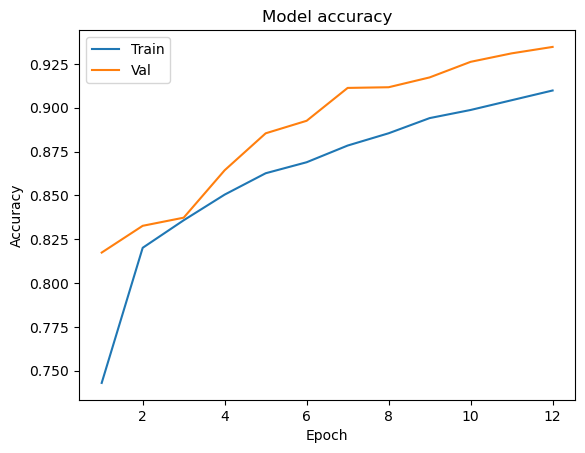

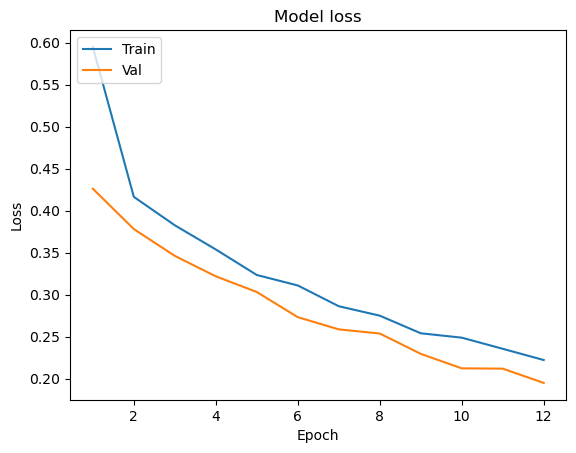

In [146]:
def plot_learningCurve(history, epochs):
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
  
plot_learningCurve(history, 12)

162/162 [==============================] - 0s 3ms/step
(5174,)
Confusion matrix:
[[1196    1  144    2]
 [  19 1289   34    2]
 [  98    6 1084   11]
 [   5    0   16 1267]]


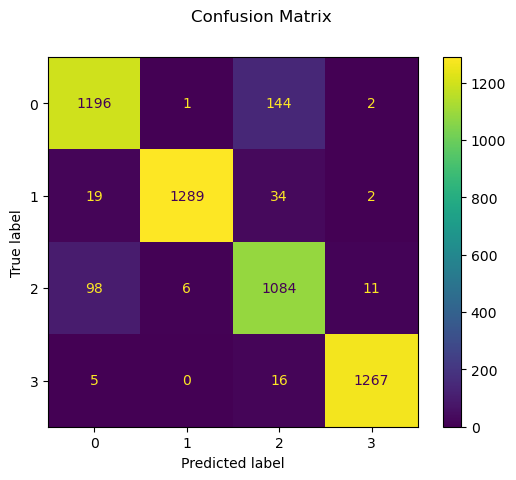

In [147]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pp = []
for i in range(0,len(y_pred)):
    y_pp.append(y_pred[i].argmax())
print(y_test.shape)
f"{sk.metrics.classification_report(y_test, y_pp)}\n"
disp = sk.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pp)
disp.figure_.suptitle("Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()